In [97]:
%pip install -q pandas torch numpy scikit-learn keras tensorflow matplotlib shap

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


The parameters:  [Parameter containing:
tensor([[ 0.2207,  0.2396, -0.0676,  0.2652, -0.0632,  0.0583, -0.1405,  0.1695,
          0.2545, -0.2118,  0.2509,  0.0540],
        [ 0.2133,  0.0391,  0.1392, -0.0408,  0.2225,  0.0427, -0.1348,  0.0736,
         -0.1330, -0.0339, -0.1172,  0.1915],
        [-0.2279, -0.1331, -0.0815, -0.1736,  0.0272, -0.2851,  0.2607, -0.2452,
          0.2229,  0.0480, -0.0937,  0.1784],
        [ 0.0450,  0.2332,  0.0316, -0.0910,  0.0776, -0.0783,  0.1215,  0.2577,
          0.1669, -0.1262,  0.1666,  0.0517],
        [ 0.1466, -0.1759, -0.2858, -0.1115, -0.2214,  0.2369,  0.0831,  0.1196,
          0.0913, -0.0050,  0.2259, -0.2051],
        [ 0.0182, -0.1970,  0.0890, -0.0994,  0.0885, -0.0601,  0.2394, -0.1711,
         -0.1722, -0.1722,  0.2596,  0.0962],
        [ 0.2778, -0.2382, -0.2863, -0.2258, -0.1942,  0.1169,  0.1034,  0.2399,
         -0.1491, -0.1968,  0.1532, -0.1167],
        [ 0.1752, -0.0685,  0.1651, -0.2243, -0.1457,  0.0880,  0.0610,

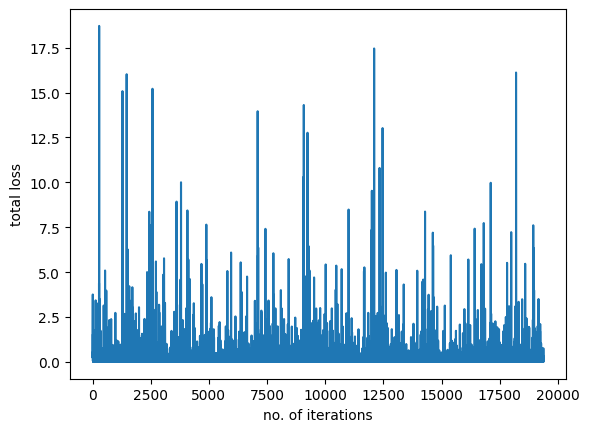

In [58]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler

torch.manual_seed(42)

# Load M4 dataset (adjust path to where your dataset is)
df = pd.read_csv('train.csv')  # Ensure it has columns 'unique_id', 'ds', 'y'

# Preprocess data: You might need to convert dates and handle missing data
#df['ds'] = pd.to_datetime(df['ds'])
#df = df.sort_values(['unique_id', 'ds'])

# You can scale the y-values for better training
scaler = StandardScaler()
df['y_scaled'] = scaler.fit_transform(df[['y']])

# Creating the dataset class for multi-target regression
class M4Dataset(Dataset):
    def __init__(self, data, sequence_length=12, target_length=3):
        """
        data: DataFrame with columns ['unique_id', 'ds', 'y']
        sequence_length: Number of previous time steps to consider for prediction
        target_length: Number of future time steps to predict
        """
        self.data = data
        self.sequence_length = sequence_length
        self.target_length = target_length
        self.unique_ids = data['unique_id'].unique()
        
    def __getitem__(self, idx):
        # Select a random unique_id for this batch
        unique_id = self.unique_ids[idx]
        data_by_id = self.data[self.data['unique_id'] == unique_id]

        # We need to take the last `sequence_length` data points for X
        X = data_by_id['y_scaled'].values[-(self.sequence_length+1):-1]
        
        # The next `target_length` values are the targets
        y = data_by_id['y_scaled'].values[-self.target_length:]

        # Convert to tensors
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(0)  # Shape (1, sequence_length)
        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(0)  # Shape (1, target_length)
        
        return X_tensor, y_tensor

    def __len__(self):
        return len(self.unique_ids)

# Creating dataset object for multi-target regression
sequence_length = 12  # Use 12 time steps to predict the next 3 values
target_length = 3  # We want to predict the next 3 time steps
dataset = M4Dataset(df, sequence_length=sequence_length, target_length=target_length)

class MultipleLinearRegression(torch.nn.Module):
    # Constructor
    def __init__(self, input_dim, output_dim, dropout_prob=0.5):
        super(MultipleLinearRegression, self).__init__()
        
        # Define the layers
        self.linear1 = torch.nn.Linear(input_dim, 64)  # First linear layer
        self.dropout = torch.nn.Dropout(dropout_prob)  # Dropout layer
        self.linear2 = torch.nn.Linear(64, output_dim)  # Second linear layer

    # Prediction
    def forward(self, x):
        x = torch.relu(self.linear1(x))  # Apply ReLU activation after first linear layer
        x = self.dropout(x)  # Apply dropout after ReLU activation
        x = self.linear2(x)  # Output layer (no activation for regression)
        return x
    
# Model setup
MLR_model = MultipleLinearRegression(sequence_length, target_length)
print("The parameters: ", list(MLR_model.parameters()))

# Defining the model optimizer and loss function
optimizer = torch.optim.SGD(MLR_model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Create the DataLoader
train_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)

# Train the model
losses = []
epochs = 20
for epoch in range(epochs):
    for x, y in train_loader:
        y_pred = MLR_model(x)
        loss = criterion(y_pred, y)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"epoch = {epoch}, loss = {loss.item()}")
print("Done training!")

# Plot the losses
plt.plot(losses)
plt.xlabel("no. of iterations")
plt.ylabel("total loss")
plt.show()

In [60]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

# Load your datasets
df = pd.read_csv('train.csv')  # Ensure it has columns 'unique_id', 'ds', 'y'
test = pd.read_csv('test.csv')  # Ensure it has columns 'unique_id', 'ds', 'y'

# Combine train and test data for scaling (ensure test data is transformed, not fitted)
scaler = StandardScaler()

# Fit scaler only on the training data
df['y_scaled'] = scaler.fit_transform(df[['y']])

# Apply the same scaler transformation to the test data (do not fit)
test['y_scaled'] = scaler.transform(test[['y']])

# Combine the train and test data for model evaluation
data = pd.concat([df, test])

# Sort and select the last 15 rows for evaluation (ensure there's enough history for predictions)
data = data.sort_values(by=["unique_id", "ds"]).groupby("unique_id").tail(15)

# Dataset and sequence parameters
sequence_length = 12  # Use 12 time steps to predict the next 3 values
target_length = 3  # We want to predict the next 3 time steps
dataset = M4Dataset(data, sequence_length=sequence_length, target_length=target_length)



KeyboardInterrupt: 

In [85]:

# RMSE calculation function per group
def calculate_rmse_per_group(model, dataset, scaler):
    model.eval()  # Set the model to evaluation mode
    
    rmse_per_group = {}

    # Iterate over each group (unique_id)
    for i, unique_id in enumerate(dataset.unique_ids):
        # Filter the dataset for the current group
        group_data = dataset[i]  # Find samples for the current unique_id

        total_squared_error = 0
        total_samples = 3

        # Calculate RMSE for the current group
        with torch.no_grad():
            # Get the model's prediction
            y_pred = model(group_data[0][0])
            # Inverse transform the predictions and actual values to original scale
            y_pred_original = scaler.inverse_transform(y_pred.squeeze().cpu().numpy().reshape(-1, 1))
            y_original = scaler.inverse_transform(group_data[1][0].squeeze().cpu().numpy().reshape(-1, 1))

            # Calculate squared error for each prediction on the original scale
            squared_error = (y_pred_original - y_original) ** 2
            total_squared_error += squared_error.sum()  # Sum of squared errors
            total_samples += y_original.size  # Total number of elements in the target tensor
        
        # Calculate RMSE for the current group
        rmse = np.sqrt(total_squared_error / total_samples)
        rmse_per_group[unique_id] = rmse

    return rmse_per_group

# Example: Calculate RMSE per group
rmse_per_group = calculate_rmse_per_group(MLR_model, dataset, scaler)

In [93]:
data = pd.DataFrame(list(rmse_per_group.items()), columns=['unique_id', 'value'])


In [96]:
data["value"].describe()

count      969.000000
mean       388.929291
std        628.546631
min         16.872812
25%        131.302780
50%        223.160629
75%        413.208832
max      11363.539062
Name: value, dtype: float64

100%|██████████| 969/969 [00:35<00:00, 27.66it/s]


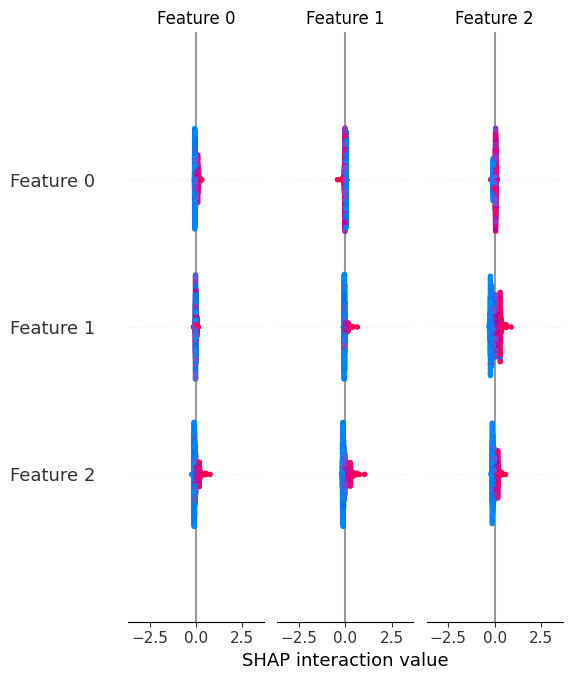

In [ ]:
import shap
import torch
import numpy as np

# Prepare the function for SHAP to call to get predictions from the model
def model_predict(x):
    x_tensor = torch.tensor(x, dtype=torch.float32).to(device)  # Convert to tensor and move to device
    with torch.no_grad():
        y_pred = MLR_model(x_tensor)  # Forward pass through the model
    return y_pred.cpu().numpy()  # Convert the tensor back to a numpy array on the CPU

# Prepare the test dataset for SHAP
# Assuming your dataset is a list of tuples (input, target), where input is a tensor
X_test = np.array([item[0][0].numpy() for item in dataset])  # Convert the input features to numpy array (2D)

# Check the shape of X_test to make sure it's 2D
if X_test.ndim == 1:
    X_test = X_test.reshape(-1, 1)  # If only one feature, reshape to 2D

# Use shap.kmeans to reduce the background dataset size to 100 samples (for example)
background_data = shap.kmeans(X_test, 10)  # Use K-means to reduce background to 100 samples

# Initialize SHAP Explainer with KernelExplainer using reduced background data
explainer = shap.KernelExplainer(model_predict, background_data)

# Compute Shapley values for the entire test set
shap_values = explainer.shap_values(X_test)

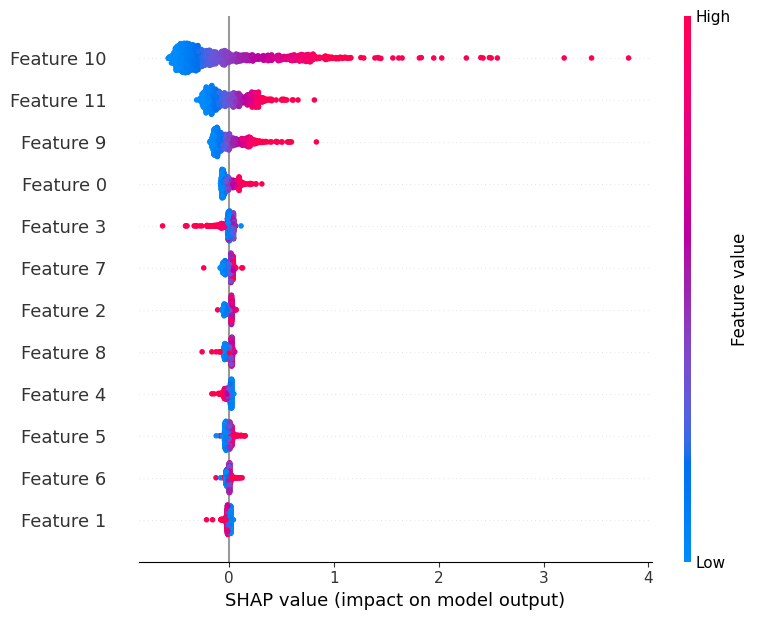

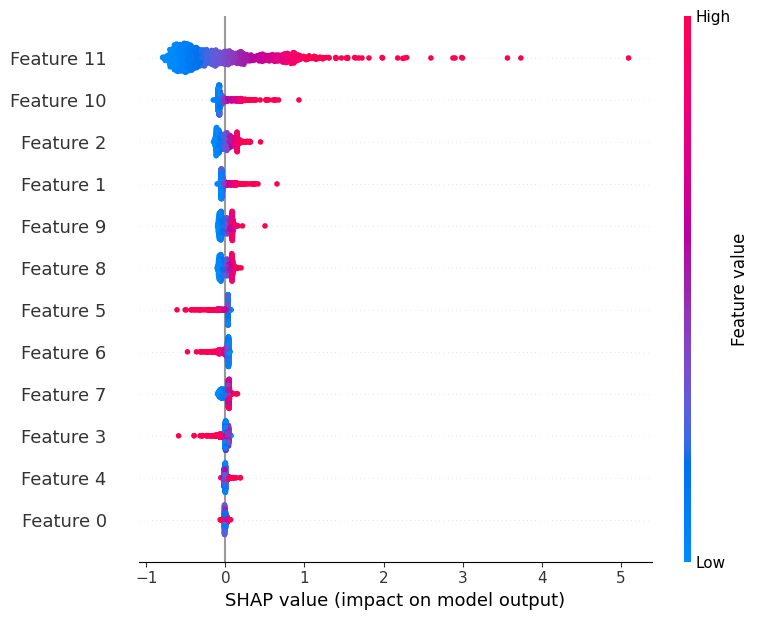

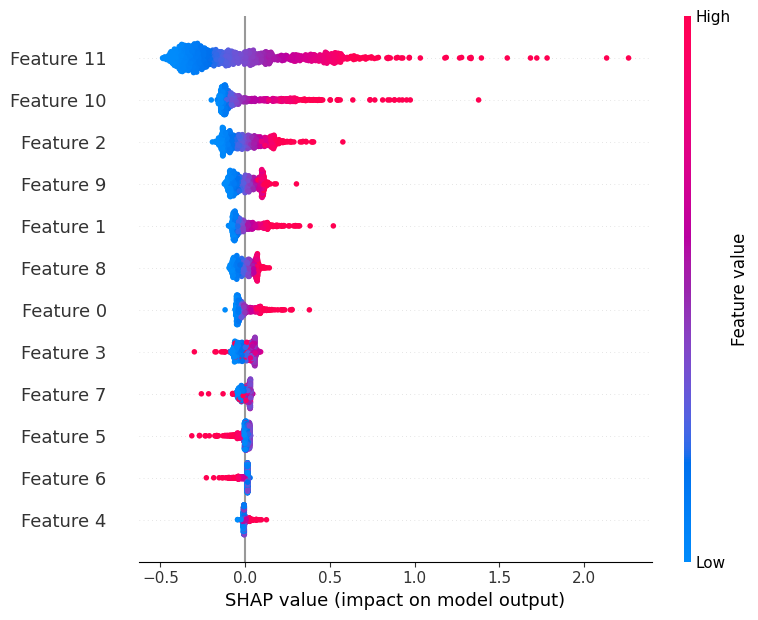

In [153]:
# Visualize SHAP values for each output
for i in range(shap_values.shape[2]):  # Loop over each output (3 in total)
    shap.summary_plot(shap_values=shap_values[:, :, i], features=X_test)